<a href="https://colab.research.google.com/github/auriwan/Stock_Time_Series/blob/main/Membuat_Model_Machine_Learning_dengan_Data_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Auriwan yasper

E-mail : auriwanyasper@gmail.com

# Import Modul

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from sklearn.model_selection import train_test_split

# Persiapan DataSet

upload dataset

In [ ]:
dataset = files.upload()

Saving AVA.csv to AVA.csv


Mengubah dataset menjadi dataframe

In [ ]:
df = pd.read_csv('AVA.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1973-02-21,0.000000,10.500000,10.437500,10.437500,0.755265,10200
1,1973-02-22,0.000000,10.500000,10.375000,10.437500,0.755265,5600
2,1973-02-23,0.000000,10.562500,10.437500,10.500000,0.759787,1800
3,1973-02-26,0.000000,10.562500,10.437500,10.500000,0.759787,7200
4,1973-02-27,0.000000,10.500000,10.500000,10.500000,0.759787,2400
...,...,...,...,...,...,...,...
11879,2020-03-26,37.490002,40.750000,37.490002,40.259998,40.259998,640200
11880,2020-03-27,39.000000,42.730000,38.720001,40.900002,40.900002,441600
11881,2020-03-30,41.930000,45.830002,41.369999,44.369999,44.369999,1201900
11882,2020-03-31,43.750000,43.849998,41.639999,42.490002,42.490002,964300


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11884 entries, 0 to 11883
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       11884 non-null  object 
 1   Open       11884 non-null  float64
 2   High       11884 non-null  float64
 3   Low        11884 non-null  float64
 4   Close      11884 non-null  float64
 5   Adj Close  11884 non-null  float64
 6   Volume     11884 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 650.0+ KB


check apakah ada data yang hilang

In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

plot data dengan matplotlib

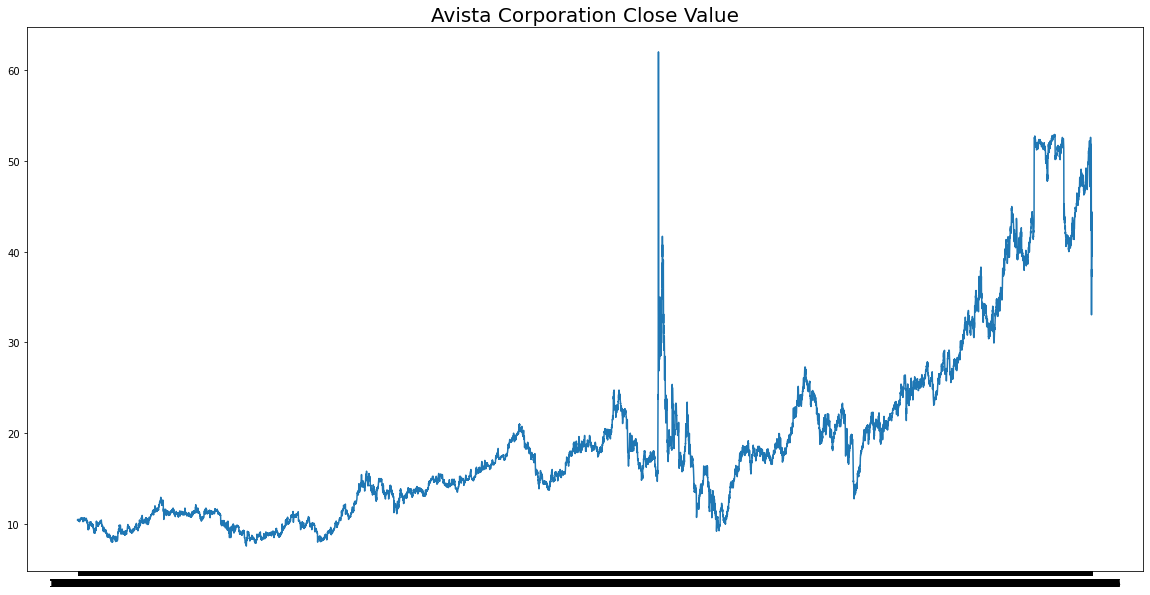

In [ ]:
#ekstraksi date dan close
date = df['Date'].values
close = df['Close'].values

#plot data
plt.figure(figsize = (20, 10))
plt.plot(date, close)
plt.title('Avista Corporation Close Value', fontsize = 20);


# Merancang Model

Membagi data menjadi data train dan data test

In [ ]:
data_train, data_test, close_train, close_test = train_test_split(date, close, test_size=0.2, shuffle=False)

Mempersiapkan Model dengan Fungsi Windowed

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(close_train, window_size = 60, batch_size = 100, shuffle_buffer = 1000)
test_set = windowed_dataset(close_test, window_size = 60, batch_size = 100, shuffle_buffer = 1000)

Merancang Model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

# Training Model dengan fungsi callback

Mempersiapkan Callback

In [ ]:
# Menghitung MAE
MAE = 0.1*(max(df.Close)-min(df.Close))
MAE

5.4437500000000005

In [ ]:
# Inisiasi fungsi callback dengan syarat akurasi 90%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')<MAE) & (logs.get('val_mae')<MAE):
      print('\nMAE telah mencapai <10%!')
      self.model.stop_training = True

callback = myCallback()

compile dan training

In [ ]:
# Compile Model
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

# Training Model
history = model.fit(
    train_set,
    batch_size = 3000,                
    epochs=100,              
    validation_data=test_set,
    callbacks=callback,      
    verbose=1)               

Epoch 1/100
95/95 [==============================] - 10s 35ms/step - loss: 13.8228 - mae: 14.3228 - val_loss: 34.5029 - val_mae: 35.0029
Epoch 2/100
95/95 [==============================] - 2s 22ms/step - loss: 11.6981 - mae: 12.1981 - val_loss: 30.7301 - val_mae: 31.2301
Epoch 3/100
95/95 [==============================] - 2s 23ms/step - loss: 3.6125 - mae: 4.0961 - val_loss: 15.7177 - val_mae: 16.2177
Epoch 4/100
95/95 [==============================] - 2s 23ms/step - loss: 3.5309 - mae: 4.0037 - val_loss: 15.9936 - val_mae: 16.4936
Epoch 5/100
95/95 [==============================] - 2s 21ms/step - loss: 3.2763 - mae: 3.7472 - val_loss: 15.8938 - val_mae: 16.3938
Epoch 6/100
95/95 [==============================] - 2s 22ms/step - loss: 2.9816 - mae: 3.4477 - val_loss: 15.9159 - val_mae: 16.4159
Epoch 7/100
95/95 [==============================] - 2s 23ms/step - loss: 2.8187 - mae: 3.2827 - val_loss: 15.7610 - val_mae: 16.2610
Epoch 8/100
95/95 [==============================] - 2s 2

Membuat plot loss dan akurasi pada saat training dan validation.

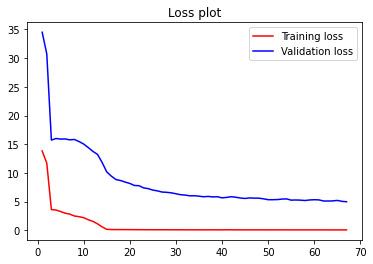

In [ ]:
# Mengambil nilai MAE dan loss dari training model
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# Plot loss
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss plot')
plt.legend()

plt.show()

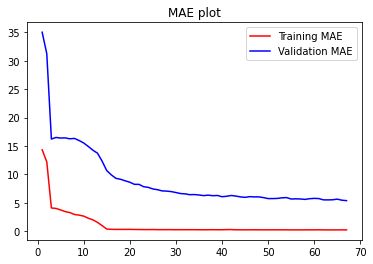

In [ ]:
# Plot MAE
plt.plot(epochs, mae, 'r', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('MAE plot')
plt.legend()
plt.show()